
# aSPEM Experiment : analysis

https://scikit-learn.org/stable/auto_examples/neighbors/plot_nearest_centroid.html#sphx-glr-auto-examples-neighbors-plot-nearest-centroid-py




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%load_ext autoreload
%autoreload 2
#from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from aSPEM import aSPEM
import bayesianchangepoint as bcp

%matplotlib inline

In [2]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [3]:
list_sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']

nb_sujet = len(list_sujet)
COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan'] #[(0+(1/nb_sujet)*n, 0, 0, 0.5) for n in range(nb_sujet)]

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [5]:
fig_width = 15
t_titre = 70
t_label = (30*4)/3

## Data Scalling

## Find h

In [6]:
with open('H_mean.pkl', 'rb') as fichier :
    H_ = pickle.load(fichier, encoding='latin1')
h_bet_m, h_va_m = H_['h_bet'], H_['h_va']

with open('H_leaky.pkl', 'rb') as fichier :
    H_ = pickle.load(fichier, encoding='latin1')
h_bet_l, h_va_l = H_['h_bet'], H_['h_va']


In [7]:
def scatter_mean(h_bet, h_va, maxx=0.55, maxy=0.25, minx=0, miny=0, ex=0.02, ey=0.01, log=True, cent=False, 
                 color=False, title=None, fig_width=10, axs=None, distance=False) :
    
    from matplotlib.patches import Ellipse
    from matplotlib.transforms import ScaledTranslation
    
    if axs is None : fig, ax = plt.subplots(1, 1, figsize=((fig_width), (fig_width)), constrained_layout=True) #/(1.6180*1))
    else :                ax = axs
    ax.set_title(title, fontsize=t_label*2)
    
    
    H = np.zeros((2, 11, 12))
    for i, s in enumerate(list_sujet) :
        H[0, :, i], H[1, :, i] = h_bet['100'][s], h_va['100'][s]
    D = (H[:, :, None]-H[:, None, :])**2#.sum(axis=0)
    print('\n', title, ' :\n', 'distance moyenne pour tout les sujets : ', np.nanmean(D.sum(axis=0)), sep='')
    
    if log: ax.set_xscale('log') ; ax.set_yscale('log')

    
    l_100_bet, l_100_va = [], []
    for x, s in enumerate(list_sujet) :
        
        '''print('%s=%.2f,'%(s, D.sum(axis=0)[:,:,x].mean()) if x!=len(list_sujet)-1
              else '%s=%.2f\n'%(s, D.sum(axis=0)[:,:,x].mean()), end=' ')'''
        
        print('%s=%.2f,'%(s, np.nanmean(D.sum(axis=0)[:,:,x])), end=' ')
        
        if color is False : c = 'k'
        else :              c = color[x]

        l_100_bet.append(h_bet['100'][s]) ; l_100_va.append(h_va['100'][s])
        ax.scatter(l_100_bet[x], l_100_va[x], color=c,  s=25, alpha=0.9)
        
        #ells = Ellipse((np.mean(l_100_bet[x]), np.mean(l_100_va[x])),
        #               np.std(l_100_bet[x]), np.std(l_100_va[x]),
        #               0, color=c, alpha=0.5, clip_box=ax.bbox)
        #ax.add_artist(ells)
        #ax.scatter(np.mean(l_100_bet[x]), np.mean(l_100_va[x]), color=c,  s=100, marker='H')
        
        #ax.scatter(D[0, :, :, x], D[1, :, :, x], color=c,  s=25, alpha=0.9)
        
        for h in range(2) :
            list_del = []
            for i in range(11) :
                for j in range(11) :
                    if D[h,i,j,x]> D[h,:,:,x].mean()+ D[h,:,:,x].std()*2 :
                        if i not in list_del : list_del.append(i)
            for i in list_del :
                D[h, i, :, x] = np.nan
                D[h, :, i, x] = np.nan
            
        print('new=%.2f,'%(np.nanmean(D.sum(axis=0)[:,:,x])) if x!=len(list_sujet)-1
              else 'new=%.2f\n'%(np.nanmean(D.sum(axis=0)[:,:,x])), end=' ')

        ax.scatter(np.nanmean(D[0, :, :, x]), np.nanmean(D[1, :, :, x]), color=c,  s=200, marker='X')
        ells = Ellipse((np.nanmean(D[0, :, :, x]), np.nanmean(D[1, :, :, x])),
                        np.nanstd(D[0, :, :, x]),  np.nanstd(D[1, :, :, x]),
                        0, color=c, alpha=0.5, clip_box=ax.bbox)
        ax.add_artist(ells)
         
    #ax.scatter(np.mean(l_100_bet), np.mean(l_100_va), color='k',  s=200, marker='H')
    #ells = Ellipse((np.mean(l_100_bet), np.mean(l_100_va)), np.std(l_100_bet), np.std(l_100_va),
    #               0, color='k', alpha=0.5, clip_box=ax.bbox)
    #ax.add_artist(ells)

    ax.scatter(np.nanmean(D[0]), np.nanmean(D[1]), color='k',  s=200, marker='X')
    ells = Ellipse((np.nanmean(D[0]), np.nanmean(D[1])), np.nanstd(D[0]), np.nanstd(D[1]),
                   0, color='k', alpha=0.5, clip_box=ax.bbox)
    ax.add_artist(ells)
    
    
    ax.plot(np.arange(-10,10), np.arange(-10,10), '--k')
    ax.vlines(0.025, -ey, 0.025, colors='k') ; ax.hlines(0.025, -ex, 0.025, colors='k')

    
    ax.set_xlabel('h$_{bet}$', fontsize=t_label) ; ax.set_ylabel('h$_{v_a}$', fontsize=t_label)
    ax.tick_params(axis='both', labelsize=t_label/1.8)
    ax.axis([minx-ex ,maxx+ex,miny-ey,maxy+ey])
    
    if axs is None :
        fig.tight_layout()
        return fig, ax
    else : return ax, D

In [8]:
COLOR = ['crimson', 'saddlebrown', 'violet', 'darkseagreen', 'dimgrey', 'teal',
         'slateblue', 'firebrick', 'peru', 'darkolivegreen', 'goldenrod', 'lightblue']


Leaky :
distance moyenne pour tout les sujets : 0.18349817050296788
AM=0.26, new=0.16, BMC=0.07, new=0.02, CS=0.11, new=0.02, DC=0.08, new=0.02, FM=0.11, new=0.01, IP=0.19, new=0.07, LB=0.13, new=0.01, OP=0.36, new=0.13, RS=0.37, new=0.20, SR=0.04, new=0.01, TN=0.20, new=0.16, YK=0.27, new=0.06
 
Mean :
distance moyenne pour tout les sujets : 0.10465135800493294
AM=0.21, new=nan, BMC=0.05, new=0.00, 

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


CS=0.10, new=0.00, DC=0.09, new=0.05, FM=0.04, new=0.01, IP=0.07, new=0.01, LB=0.03, new=0.01, OP=0.11, new=0.03, RS=0.30, new=0.26, SR=0.04, new=0.02, TN=0.02, new=0.01, YK=0.20, new=0.03
 

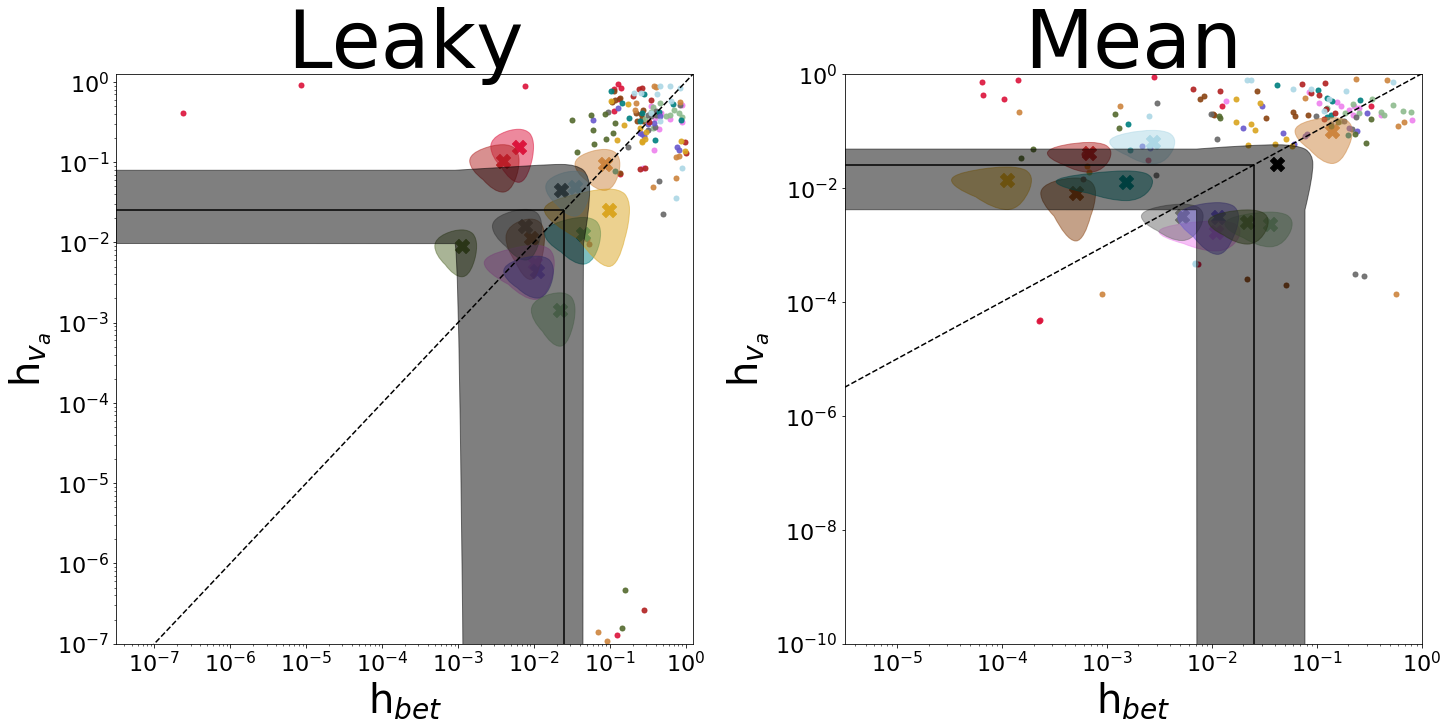

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10*2, 10), constrained_layout=True)
ax[0], D_l = scatter_mean(h_bet_l, h_va_l, axs=ax[0], title='Leaky',
                     maxx=10**0.1, maxy=10**0.1, minx=10**-7.5, miny=10**-7,
                     ex=0, ey=0, color=COLOR, cent=True, distance=True)

ax[1], D_m = scatter_mean(h_bet_m, h_va_m, axs=ax[1], title='Mean',
                     maxx=10**0, maxy=10**0, minx=10**-5.5, miny=10**-10,
                     ex=0, ey=0, color=COLOR, cent=True, distance=True)

#for ext in exts: fig.savefig(f'{msfigpath}/5_inter-individual_differences_fit' + ext, dpi=dpi)

## Calcule MI

In [10]:
Full = e.Full_list()

In [11]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    https://matthew-brett.github.io/teaching/mutual_information.html"""
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mumu(p, data) :
    hist, x_edges, y_edges = np.histogram2d(p, data ,bins=20)
    return mutual_information(hist)

In [12]:
def find_mumu(h_bet, h_va) :
    HBET, HVA = [], []
    for suj in list_sujet :
        HBET.extend(h_bet['block'][suj])
        HVA.extend(h_va['block'][suj])
    
    print('h_bet : mean=%s, std=%s'%(np.nanmean(HBET), np.nanstd(HBET)))
    print('h_va : mean=%s, std=%s'%(np.nanmean(HVA), np.nanstd(HVA)))
    
    mu_bet,mu_va = [], []
    for suj in list_sujet :
        for b in range(3) :
            result = Full[Full.sujet==suj]['results'][200*b:200*(b+1)]
            va = Full[Full.sujet==suj]['va'][200*b:200*(b+1)]

            bino = Full[Full.sujet==suj]['bino'][200*b:200*(b+1)]

            p_hat_bet, p_hat_va = [], []
            liste = [0,50,100,150,200]
            for s in range(len(liste)-1) :

                p_bar, r_bar, beliefs = bcp.inference(np.asarray(bino[liste[s]:liste[s+1]]), h=h_bet['block'][suj][b], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')
                p_hat_bet.extend(p_hat)

                p_bar, r_bar, beliefs = bcp.inference(np.asarray(bino[liste[s]:liste[s+1]]), h=h_va['block'][suj][b], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode='mean')
                p_hat_va.extend(p_hat)

            mu_bet.append(mumu(p_hat_bet, result))

            proba = np.ma.masked_array(p_hat_va, mask=np.isnan(va.tolist())).compressed()
            data = np.ma.masked_array(va.tolist(), mask=np.isnan(va.tolist())).compressed()

            mu_va.append(mumu(proba, data))
    
    print('mumu h_bet : mean=%s, std=%s'%(np.nanmean(mu_bet), np.nanstd(mu_bet)))
    print('mumu h_va : mean=%s, std=%s'%(np.nanmean(mu_va), np.nanstd(mu_va)))

In [13]:
find_mumu(h_bet_m, h_va_m)

h_bet : mean=0.1387997664369719, std=0.18012915544859032
h_va : mean=0.2619282403949119, std=0.1957761085243669
mumu h_bet : mean=1.0255601237296388, std=0.3418048976669125
mumu h_va : mean=0.7426902388779366, std=0.20955591546288668


In [14]:
find_mumu(h_bet_l, h_va_l)

h_bet : mean=0.3419019908814192, std=0.2161050030017866
h_va : mean=0.3935054649201287, std=0.21537691391610905
mumu h_bet : mean=0.9173909155290466, std=0.3547181806949145
mumu h_va : mean=0.6531424614151002, std=0.21759086191445987


# Classifier

#TODO prune methods
#TODO plots: loglog + centrer
#TODO cross-validation LOO
#TODO compare with fixed / real
